In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
import sys
from biodata.delimited import DelimitedWriter
from matplotlib.ticker import FormatStrFormatter
from collections import defaultdict

In [2]:
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import utils

In [3]:
import matplotlib
from pathlib import Path
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [4]:
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/"
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

In [5]:
sys.path.append(f"{PROJECT_DIR_s}2_train_models/")
from data_loading import extract_observed_profiles, one_hot_encode
from file_configs import MergedFilesConfig
from hyperparams import DefaultParams as Params
sys.path.append(f"{PROJECT_DIR_s}6_call_motifs/")
from call_motifs_script import load_coords

# Examples

In [6]:
s = "HCT116"
ks = ["pl", "mn"]
types = ["wt", "mt"]
model_type = "strand_merged_umap"
motif = "AP1"
merged_config = MergedFilesConfig(s, model_type, f"{PROJECT_DIR_o}procapnet/")
peak_path = merged_config.all_peak_path
params = Params()
in_window = params.in_window

In [37]:
counts_hits_path = f"{PROJECT_DIR_o}procapnet/motifs_out/{s}/{model_type}/merged/counts_hits.bed"
df_motifs = pd.read_table(counts_hits_path, header=None)
motifs = defaultdict(list)
for index, row in df_motifs.iterrows():
	if row[3] == motif:
		m_start, m_end = row[1:3]
		motifs[row[4]].append((m_start, m_end))

In [8]:
# Input peak boundary for ProCapNet

coords = load_coords(peak_path, in_window=in_window)

In [9]:
# Pick examples

regions = [# Up
		   ("chr6", 3174103, 3175103),
		   # Down
		   ("chr18", 63365967, 63366967)
		  ]

In [35]:
for r in regions:
	print(motifs[coords.index(r)])

[(3174562, 3174569, '+')]
[(63366453, 63366460, '+')]


In [11]:
outputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example.bed"
with DelimitedWriter(outputfile) as dw:
	for r in regions:
		chrom, start, end = r
		dw.write([chrom, start, end])

# Observed profiles

In [12]:
bws = [f"{PROJECT_DIR_d}Alignments/brm_CTCF_U1_and_CTCF_U2_erm_5{k}.bw" for k in ks]
obs_profs = extract_observed_profiles(bws[0],
									bws[1],
									f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example.bed",
									out_window=500)

== In Extract Profiles ==
Peak filepath: /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_AP1_example.bed
Profile length: 500
Num. Examples: 2


# Predicted profiles

## Get sequences

In [13]:
inputfile = f"{PROJECT_DIR_r}genomes/human/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
with open(inputfile, "r") as f:
	fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [14]:
def get_sequences(regions, outputfile, fdict, t, motifs):
	seqs = []
	for r in regions:
		chrom, start, end = r
		seq = fdict[chrom][start:end].seq.upper()
		wt_seq = one_hot_encode(seq)
		if t == "wt":
			seqs.append(wt_seq.T)
		else:
			mut_start, mut_end = motifs[coords.index(r)][0]
			# in-silico deletion: replace motif instance with [0,0,0,0]
			mt_seq = wt_seq
			for i in range(mut_start-int(start), mut_end-int(start)):
				mt_seq[i] = [0,0,0,0]
			seqs.append(mt_seq.T)
	seqs = np.array(seqs)
	np.save(outputfile, seqs)

In [15]:
for t in types:
	outputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.npy"
	get_sequences(regions, outputfile, fdict, t, motifs)

## Prediction

In [16]:
script = f"{PROJECT_DIR_s}slurm/predict.sh"
scale = "True"
model_type = "strand_merged_umap"
for t in types:
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.npy"
	output_prefix = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}."
	commands = ["sbatch", script,
				s,
				model_type,
				f"{PROJECT_DIR_o}procapnet/",
				inputfile,
				output_prefix,
				scale,
				str(types.index(t))
				]
	print(" ".join(commands))

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/predict.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_AP1_example_wt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_AP1_example_wt. True 0
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/predict.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_AP1_example_mt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_AP1_example_mt. True 1


In [27]:
pred_profs = {}
for t in types:
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.scaled_profiles.npy"
	pred_profs[t] = np.load(inputfile)

## Contribution scores

In [18]:
script = f"{PROJECT_DIR_s}slurm/interpret_any.sh"
for t in types:
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.npy"
	output_prefix = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}."
	commands = ["sbatch", script,
				s,
				model_type,
				f"{PROJECT_DIR_o}procapnet/",
				inputfile,
				output_prefix,
				str(types.index(t))
				]
	print(" ".join(commands))

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/interpret_any.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_AP1_example_wt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_AP1_example_wt. 0
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/interpret_any.sh HCT116 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_AP1_example_mt.npy /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/prediction/HCT116_AP1_example_mt. 1


In [29]:
# One-hot scores

scores = {}
for t in types:
	inputfile = f"{PROJECT_DIR_o}procapnet/prediction/{s}_{motif}_example_{t}.count_scores.npy"
	scores[t] = np.load(inputfile)

# Browser shots

In [20]:
def plot_PROcap(array, ax):
    orientations = {"fwd": "red", "rev": "blue"}
    results = [[i, array[0][i], "fwd"] for i in range(500)]
    results += [[i, -array[1][i], "rev"] for i in range(500)]
    results += [[500, np.nan, "fwd"], [500, np.nan, "rev"]]
    df = pd.DataFrame(results, columns=["position", "reads", "orientation"])
	
    for orientation, color in orientations.items():
        df_orientation = df[df["orientation"] == orientation]
        ax.bar(df_orientation["position"], df_orientation["reads"], color=color, align="edge", width=2)

In [21]:
def plot_scores(array, ax):
	utils.plot_weights(array[:, 250:750], ax)
	ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

In [22]:
def PROcap_contribution_scores(obs_profs, pred_profs, scores, region, color, ylims, yticks, xlims, outputfile):
	nrow = 5
	fig, ax = plt.subplots(nrow, 1, figsize=(5.2,5.8))

	chrom, start, end = region
	start = start + 250
	start2, end2 = motifs[coords.index(region)][0]
	m_start = start2-start
	m_end = end2-start
	n = regions.index(region)
	
	for k in range(nrow):
		if k == 0:
			# Observed PROcap signals
			plot_PROcap(obs_profs[n], ax[k])
			ylabel = "Obs"
			ax[k].axhline(y=0, ls="--", c="#636363")
		elif k == 1:
			# Predicted PROcap signals (wt)
			plot_PROcap(pred_profs["wt"][n], ax[k])
			ylabel = "Pred\n(wt)"
			ax[k].axhline(y=0, ls="--", c="#636363")
		elif k == 2:
			# Contribution score (wt)
			plot_scores(scores["wt"][n], ax[k])
			ylabel = "Score\n(wt)"
			y = ylims[1]
			ax[k].fill_betweenx(y=y, x1=m_start, x2=m_end, color=color, alpha=0.3)
			ax[k].text(x=m_end-40, y=y[1]*0.5, s=motif, fontsize=bfontsize, fontweight="bold", color=color)
		elif k == 3:
			# Predicted PROcap signals (mt)
			plot_PROcap(pred_profs["mt"][n], ax[k])
			ylabel = "Pred\n(mt)"
			ax[k].axhline(y=0, ls="--", c="#636363")
		else:
			# Contribution score (mt)
			plot_scores(scores["mt"][n], ax[k])
			ylabel = "Score\n(mt)"
			y = ylims[1]
			ax[k].fill_betweenx(y=y, x1=m_start, x2=m_end, color=color, alpha=0.3)
			ax[k].text(x=m_end-65, y=y[1]*0.5, s="Deletion", fontsize=bfontsize, fontweight="bold", color=color)
			
		ax[k].set_ylabel(ylabel, fontsize=bfontsize, fontweight="bold")
		ax[k].yaxis.set_label_coords(-0.12, 0.5)

		ax[k].set_xlim(xlims)
		nticks = (xlims[1]-xlims[0])//100+1
		xticks = [xlims[0]+n*100 for n in range(nticks)]
		ax[k].set_xticks(xticks)
		if k == nrow-1:
			xticklabels = [start+x for x in xticks]
			ax[k].set_xticklabels(xticklabels)
			ax[k].set_xlabel(f"Genomic position ({chrom})", fontsize=bfontsize, fontweight="bold")
		else:
			ax[k].set_xticklabels([])
			ax[k].set_xlabel("")

		ax[k].tick_params(labelsize=sfontsize)

	for k in range(nrow):
		# PROcap signals 
		if k in [0,1,3]:
			ylim = ylims[0]
			ytick = yticks[0]
		# Contribution scores
		else:
			ylim = ylims[1]
			ytick = yticks[1]
			ax[k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
			
		ax[k].set_ylim(ylim)
		ax[k].set_yticks(ytick)
		
	plt.subplots_adjust(hspace=0.2)
	plt.savefig(outputfile, bbox_inches="tight", dpi=300)

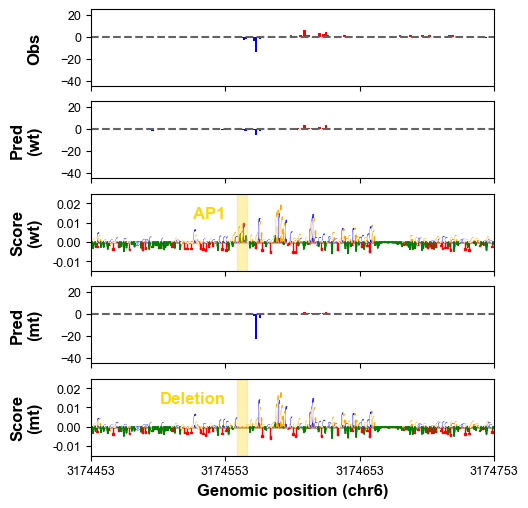

In [41]:
# Up

color = "#FFD700"
ylims = [[-45,25], [-0.015,0.025]]
yticks = [[-40,-20,0,20], [-0.01,0,0.01,0.02]]
xlims = [100,400]
outputfile = f"{PROJECT_DIR_o}figures/Fig5c.png"
PROcap_contribution_scores(obs_profs, pred_profs, scores, regions[0], color, ylims, yticks, xlims, outputfile)

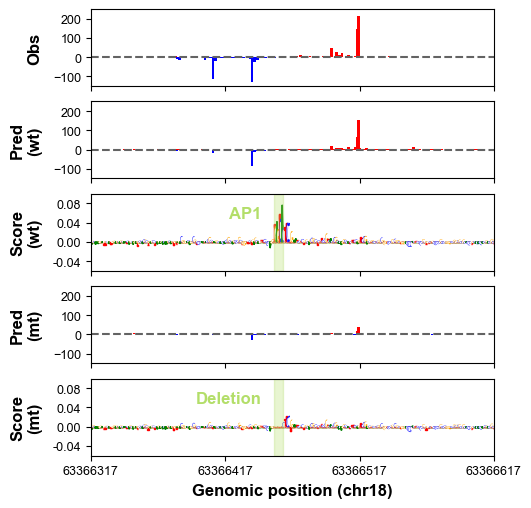

In [42]:
# Down

color = "#b3de69"
ylims = [[-150,250], [-0.06,0.1]]
yticks = [[-100,0,100,200], [-0.04,0,0.04,0.08]]
xlims = [100,400]
outputfile = f"{PROJECT_DIR_o}figures/Fig5d.png"
PROcap_contribution_scores(obs_profs, pred_profs, scores, regions[1], color, ylims, yticks, xlims, outputfile)